# Análise com viés social do Exame Nacional do Ensino Médio 2019

## Primeiros passos


Vamos importar as bibliotecas que serão utilizadas no notebook.

In [95]:
import re
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns

### escolhendo os estilos para a visualização do dados

Para visualizar melhor os dados utilizaremos o seguinte estilo:

In [96]:
#Estilo escolhidos para os gráficos plotados
sns.set_style('whitegrid')
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71", "#f5c740"]
sns.set_palette(flatui)

Os microdados do ENEM têm aproximadamente 3 GB, tornando muito custoso o ato de carregar o conjunto de dados por inteiro na memória. Assim, selecionaremos aleatoriamente uma amostra de pouco mais de 50 mil usuários, o que representa cerca de 1% do total de alunos que realizaram o exame em 2019.

Esse valor escolhido garante que, ainda após uma etapa futura quando removeremos algumas linhas, teremos uma amostra que apresenta 99% de grau de confiança e 0.7% de margem de erro.

In [102]:
p = 0.01

df = pd.read_csv(
    'MICRODADOS_ENEM_2019.csv',
    header=0,
    encoding = "ISO-8859-1",
    skiprows=lambda i: i > 0 and random.random() > p,
    sep=';'
)

## Preparando os dados

Feita as primeiras configurações, podemos agora começar o trabalho relacionado a preparação dos dados utilizados para gerar as visualizações desejadas. 

A fim de evitar uso desnecessário de memória e facilitar a visualização do DataFrame, vamos selecionar agora somente as colunas que podem ter algum uso nas etapas posteriores desse notebook.

In [103]:
selected_features = ['SG_UF_RESIDENCIA', 'TP_SEXO', 'TP_COR_RACA', 'Q001', 'Q002', 'Q025', 
                    'NU_NOTA_LC', 'NU_NOTA_CH', 'NU_NOTA_CN', 'NU_NOTA_MT', 'NU_NOTA_REDACAO', 'NU_IDADE']

df = df[selected_features].copy()

Agora, iremos descartar os valores nulos captados acima.

In [104]:
df.isnull().sum()

SG_UF_RESIDENCIA        0
TP_SEXO                 0
TP_COR_RACA             0
Q001                    0
Q002                    0
Q025                    0
NU_NOTA_LC          11790
NU_NOTA_CH          11790
NU_NOTA_CN          13935
NU_NOTA_MT          13935
NU_NOTA_REDACAO     11790
NU_IDADE                0
dtype: int64

In [105]:
print(f'Quantidade original de linhas: {df.shape[0]}')
df.dropna(inplace=True)
print(f'Quantidade final de linhas: {df.shape[0]}')

Quantidade original de linhas: 50915
Quantidade final de linhas: 36898


Agora podemos criar uma nova coluna chamada "media_geral", que é a soma de todas as áreas de conhecimento mais a redação divida por 5. Essa é uma coluna muito importante para nos ajudar no desenvolver desta análise.

In [106]:
#Criando uma nova coluna chamada: Média Geral.
df['media_geral'] = df[['NU_NOTA_LC','NU_NOTA_CH','NU_NOTA_CN','NU_NOTA_MT','NU_NOTA_REDACAO']].sum(axis=1)/5

__________________________________________________________________________________________________________________
Existem algumas colunas que nos dão os dados de forma numérica ou alfanumérica, e um importante passo que podemos utilizar é a substituição dos valores originais por valor mais explicativos.

Portanto, com o auxílio do dicionário de features fornecido pelo INEP, vamos realizar as substituições necessárias nas colunas que parecem ser interessantes para nosso trabalho.

In [107]:
df['TP_COR_RACA']=df['TP_COR_RACA'].replace({0:'Não decladado',
                                             1:'Branca',
                                             2:'Preta',
                                             3:'Parda',
                                             4:'Amarela',
                                             5:'Indigena'})

In [108]:
df['Q001'].replace({'A': 'Nunca estudou',
                    'B': 'Fund. incompleto',
                    'C': 'Fund. incompleto', 
                    'D': 'Medio incompleto',
                    'E': 'Medio completo',
                    'F': 'Superior completo',
                    'G': 'Pós graduação',
                    'H': 'Não sabe'}, inplace=True)

df['Q002'].replace({'A': 'Nunca estudou',
                    'B': 'Fund. incompleto',
                    'C': 'Fund. incompleto', 
                    'D': 'Medio incompleto',
                    'E': 'Medio completo',
                    'F': 'Superior completo',
                    'G': 'Pós graduação',
                    'H': 'Não sabe'}, inplace=True)

df['Q025'].replace({'A': 'Nao',
                    'B': 'Sim'}, inplace=True)

Vamos criar uma nova coluna chamada "REGIAO", a qual vai nos ajudar a analisar notas por determinadas regiões do Brasil e conhecer as características de cada uma delas.

In [109]:
def REGIAO(x):
    if any((x =='MT',x=='MS',x=='GO',x=='DF')):
        return 'CENTRO-OESTE'
    if any((x=='AM',x=='PA',x=='AC',x=='RO',x=='RR',x=='AP',x=='TO')):
        return 'NORTE'
    if any((x=='MA',x=='PI',x=='CE',x=='RN',x=='PB',x=='PE',x=='AL',x=='SE',x=='BA')):
        return 'NORDESTE'
    if any((x=='MG',x=='SP',x=='RJ',x=='ES')):
        return 'SUDESTE'
    if any((x=='PR',x=='SC',x=='RS')):
        return 'SUL'


df['REGIAO'] = df['SG_UF_RESIDENCIA'].apply(REGIAO)

Veremos abaixo que as novas colunas foram criadas e os valores originais foram trocados

In [110]:
df.head()

,SG_UF_RESIDENCIA,TP_SEXO,TP_COR_RACA,Q001,Q002,Q025,NU_NOTA_LC,NU_NOTA_CH,NU_NOTA_CN,NU_NOTA_MT,NU_NOTA_REDACAO,NU_IDADE,media_geral,REGIAO
1,PA,F,Parda,Medio completo,Fund. incompleto,Sim,551.5,578.1,426.2,499.9,500.0,23,511.14,NORTE
2,PA,F,Branca,Medio completo,Pós graduação,Sim,588.4,645.3,573.7,509.5,720.0,21,607.38,NORTE
3,PA,F,Parda,Fund. incompleto,Medio incompleto,Sim,423.0,455.9,438.9,442.8,640.0,17,480.12,NORTE
4,PA,M,Branca,Fund. incompleto,Medio completo,Sim,489.6,435.3,417.9,558.8,520.0,18,484.32,NORTE
5,PA,M,Parda,Não sabe,Medio completo,Nao,596.5,623.0,625.3,759.8,800.0,17,680.92,NORTE


Queremos então comparar a distribuição dos fatores entre as 1% melhores notas e as demais. 
A fim de fazer isso, vamos ordernar o dataset com base na recém criada coluna "media_geral".

In [111]:
df.sort_values(by=['media_geral'], ascending=False, inplace=True)
df.head()

,SG_UF_RESIDENCIA,TP_SEXO,TP_COR_RACA,Q001,Q002,Q025,NU_NOTA_LC,NU_NOTA_CH,NU_NOTA_CN,NU_NOTA_MT,NU_NOTA_REDACAO,NU_IDADE,media_geral,REGIAO
35449,MG,M,Branca,Medio completo,Medio completo,Sim,690.6,752.7,784.5,950.1,960.0,17,827.58,SUDESTE
33479,CE,M,Branca,Superior completo,Medio completo,Sim,683.9,711.2,740.4,964.5,960.0,22,812.00,NORDESTE
31393,PI,M,Parda,Medio incompleto,Medio completo,Sim,675.6,681.0,786.6,964.5,940.0,17,809.54,NORDESTE
29866,MG,M,Branca,Pós graduação,Pós graduação,Sim,656.1,689.5,747.5,963.6,960.0,20,803.34,SUDESTE
22073,PA,F,Branca,Pós graduação,Medio completo,Sim,700.6,778.6,698.1,849.8,960.0,19,797.42,NORTE


Agora, vamos selecionar os candidatos com as notas entre o primeiro centil, ou seja, que estão as 1% melhores notas. Para isso, podemos resetar o índice e atribuir True ou False para os casos que estão, respectivamente, entre as 1% das primeiras linhas.

Depois, vamos manter a ideia de manter valores representativos e substituir esses valores booleanos gerados.

In [112]:
df['RANKING'] = df.reset_index().drop(columns='index').index.to_numpy() < 1000
df['RANKING'].replace({True:  '1%',
                        False: '99%'}, inplace=True)
df.head()

,SG_UF_RESIDENCIA,TP_SEXO,TP_COR_RACA,Q001,Q002,Q025,NU_NOTA_LC,NU_NOTA_CH,NU_NOTA_CN,NU_NOTA_MT,NU_NOTA_REDACAO,NU_IDADE,media_geral,REGIAO,RANKING
35449,MG,M,Branca,Medio completo,Medio completo,Sim,690.6,752.7,784.5,950.1,960.0,17,827.58,SUDESTE,1%
33479,CE,M,Branca,Superior completo,Medio completo,Sim,683.9,711.2,740.4,964.5,960.0,22,812.00,NORDESTE,1%
31393,PI,M,Parda,Medio incompleto,Medio completo,Sim,675.6,681.0,786.6,964.5,940.0,17,809.54,NORDESTE,1%
29866,MG,M,Branca,Pós graduação,Pós graduação,Sim,656.1,689.5,747.5,963.6,960.0,20,803.34,SUDESTE,1%
22073,PA,F,Branca,Pós graduação,Medio completo,Sim,700.6,778.6,698.1,849.8,960.0,19,797.42,NORTE,1%


## Visualização de Dados

Chegamos a parte na qual iremos visualizar de fato os dados graficamente, com as bibliotecas, estilos de gráficos e paletas de cores escolhidas no inicio deste projeto.

Vamos criar um função que ajudara a compararmos os dados que queremos analisar com as melhores notas obtidas, para fins de avaliação e análise social dos períodos atuais da educação brasileira no geral.

Essa função foi retirada do arquivo "highest-scores-analysis" para padronização dos gráficos plotados.

In [118]:
def compare_distribution(column, chart_title, legend_title):
    fig, ax = plt.subplots(figsize=(15, 3)) 
    ax.set_title(chart_title) 
    sns.histplot(df, y="RANKING", hue=column, stat="probability", multiple="fill", shrink=0.8, ax=ax, edgecolor="none")
    
    sns.despine(left=True, bottom=True)
    
    ax.set_ylabel('') 
    ax.set_xlabel('Distribuição') 
    
    legends = re.findall(r"'(.*?)'", str(list(ax.get_legend().get_texts())))
    legends.reverse()
    plt.legend(legends, title=legend_title,bbox_to_anchor=(0.5,-0.2), loc='upper center', ncol=3)
    plt.show()

Para iniciarmos de fato, acho interessante vermos o número de mulheres e homens, que fizeram o exame, assim como suas idades (o que pode ser relevante também), para posteriormente analisarmos suas notas, de acordo com cor/raça, região do brasil, por grau de instrução dos parentes e condições de acesso a internet.

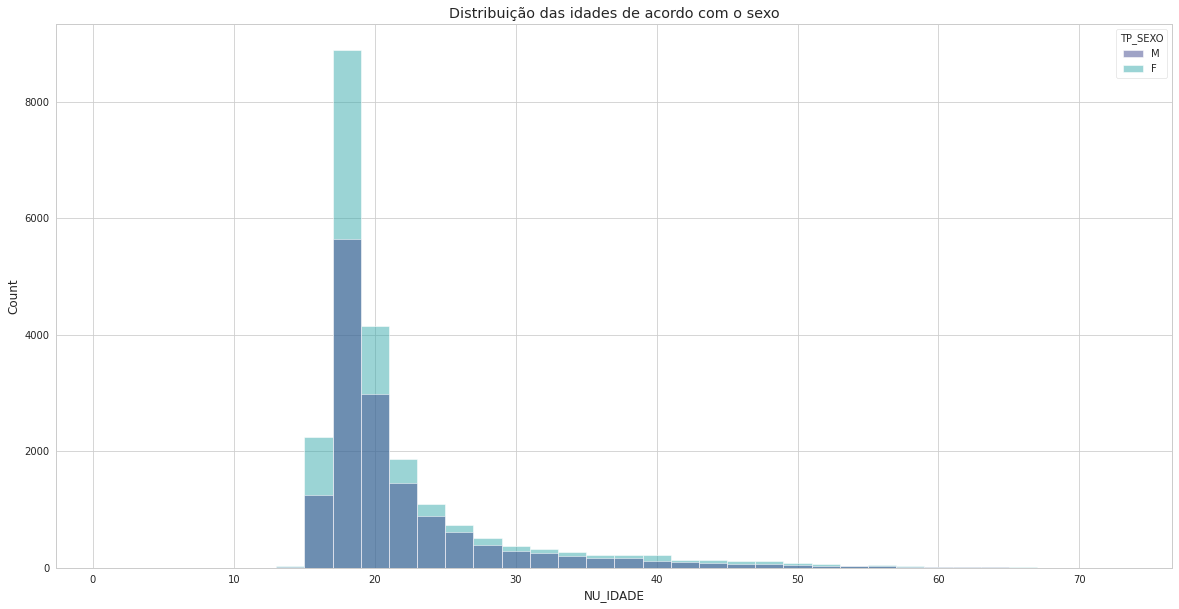

In [137]:
fig, ax = plt.subplots( figsize=(20, 10))
sns.histplot(
    data=df, x="NU_IDADE", hue="TP_SEXO",
   fill=True, common_norm=False, palette="mako",
   alpha=.5, binwidth=2,
)
ax.set_title('Distribuição das idades de acordo com o sexo'),
plt.show()

Como podemos observar acima, é evidente que a quantidade de mulheres que fazemos o exame é maior que a de homens, e em sua maioria de ambos os sexos são jovens entre 15 e 25 anos de idade.

Abaixo podemos ver mais detalhadamente separado por cada região e suas respectivas quantidades do lado esquerdo do gráfico.

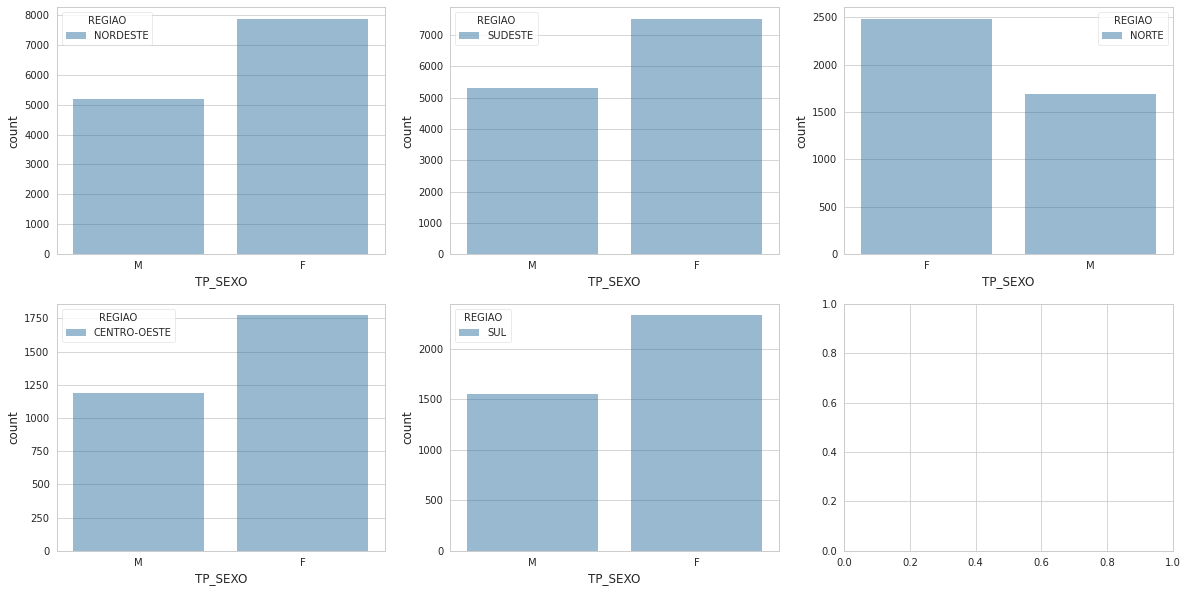

In [126]:
fig, ax = plt.subplots( 2,3, figsize=(20, 10))
sns.countplot(
   data=df.query("REGIAO == 'NORDESTE'"), x="TP_SEXO", hue="REGIAO",
   palette="tab10",
   alpha=.5, linewidth=0,
    ax=ax[0,0]
)


sns.countplot(
   data=df.query("REGIAO == 'SUDESTE'"), x="TP_SEXO", hue="REGIAO",
   palette="tab10",
   alpha=.5, linewidth=0,
    ax=ax[0,1]
)
    
sns.countplot(
   data=df.query("REGIAO == 'NORTE'"), x="TP_SEXO", hue="REGIAO",
   palette="tab10",
   alpha=.5, linewidth=0,
    ax=ax[0,2]
)

sns.countplot(
   data=df.query("REGIAO == 'CENTRO-OESTE'"), x="TP_SEXO", hue="REGIAO",
   palette="tab10",
   alpha=.5, linewidth=0,
    ax=ax[1,0]
)

sns.countplot(
   data=df.query("REGIAO == 'SUL'"), x="TP_SEXO", hue="REGIAO",
   palette="tab10",
   alpha=.5, linewidth=0,
    ax=ax[1,1]
)

plt.show()

Vamos então ver a representatividade feminina e masculina de acordo com suas médias usando outra representação gráfica:

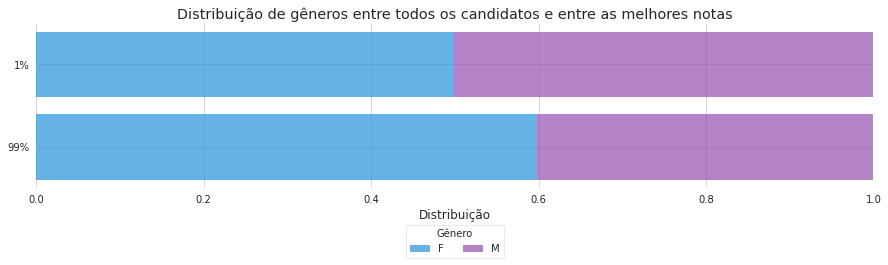

In [127]:
compare_distribution('TP_SEXO', 'Distribuição de gêneros entre todos os candidatos e entre as melhores notas', 'Gênero')

Aqui podemos notar que os homens possuem uma maior representação entre as maiores notas, estando em aproximadamente 10% mais presentes que quando comparados com o resto da população analisada.


#### Veremos agora a distribuição das melhores notas e as demais de acordo com a cor/raça de cada pessoa:

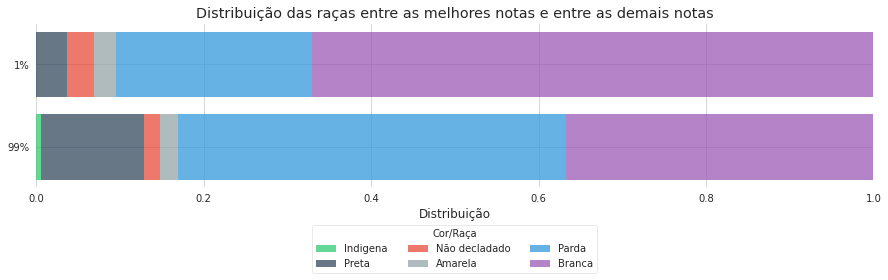

In [119]:
compare_distribution('TP_COR_RACA', 'Distribuição das raças entre as melhores notas e entre as demais notas', 'Cor/Raça')

Podemos observar que:
- A população preta, parda, indígena e não declados são pouco representados quando analisamos principalmente as melhores notas obtidas nos dados.
- Em contra partida a população branca ganha notoriedade nesta mesma análise das melhores notas.
- A população indígena é quase nula em relação as demais.

#### Agora vamos ver como as notas da população analisada varia de acordo com a formação dos seus parentes:

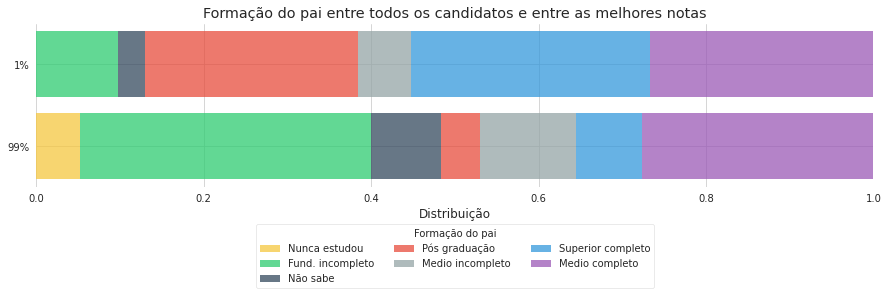

In [132]:
compare_distribution('Q001', 'Formação do pai entre todos os candidatos e entre as melhores notas', 'Formação do pai')

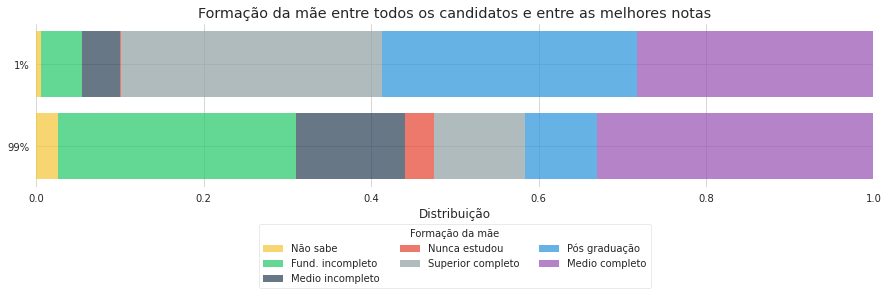

In [133]:
compare_distribution('Q002', 'Formação da mãe entre todos os candidatos e entre as melhores notas', 'Formação da mãe')

Podemos observar que:
- Alunos aos quais os pais tem uma melhor formação tendem a tirar notas melhores do que os outros como é observado no gráfico dos 1%.

#### Veremos agora a distribuição das notas de acordo com o acesso a internet na casa dos estudantes que prestaram o exame:

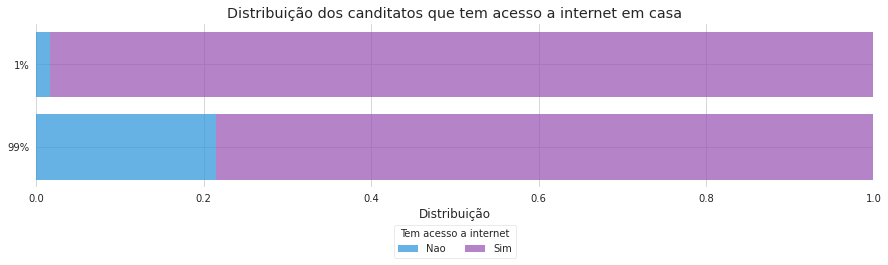

In [136]:
compare_distribution('Q025', 'Distribuição dos canditatos que tem acesso a internet em casa', 'Tem acesso a internet')

Podemos observar que:
- É gritante a distruibuição da demais notas e da melhores em relação ao acesso a internet. Mostrando que geralmente as pessoas que tem acesso a internet, conseguem tirar uma nota superior aos outros estudantes que prestam esse vestibular tão disputado no Brasil.
- Por outro lado mostra que ainda existem muitos estudantes sem acesso a internet no Brasil.

#### Veremos por último mas não menos importante a distribuição das notas por regiões do Brasil:

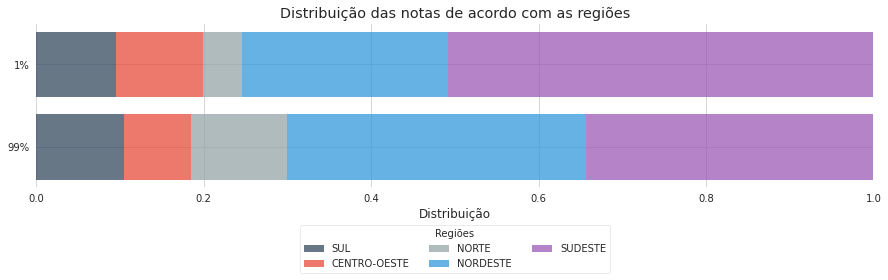

In [139]:
compare_distribution('REGIAO', 'Distribuição das notas de acordo com as regiões', 'Regiões')

Podemos observar que:
- O número de população do Sudeste do país aumenta quando se trata das melhores notas registradas.
- Apesar de menor representado a região Nordeste ainda ocupa uma grande parcela do percentual das melhores notas por regiões somente atrás do Sudeste.